# Graph extraction with Gemini and SurrealDB

    This notebook demonstrates the process of extracting a knowledge graph from unstructured text and storing it in the SurrealDB database. The process involves several steps:

### Data Loading: 
    Loads the raw text data from which the knowledge graph will be extracted.


### Using an LLM (in this example Gemini):

    Using a prompt template (prompts.py) modified from a Microsoft GraphRag example we ask Gemini to do the following

#### Entity Recognition: 
    Identifies and extracts key entities (people, organizations, locations, etc.) from the text. 

#### Relationship Extraction:
    Determines relationships between the extracted entities.




### Constructing the Knowledge Graph with Surreal: 
    Converts the extracted entities and relationships into a knowledge graph stored in SurrealDB. This involves:

        Mapping entities to nodes and relationships to edges in the graph.

        Using SurrQL statements (CREATE for nodes, RELATE for edges) to populate the knowledge graph in the database.


### Connecting to SurrealDB:
    Establishes a connection to the SurrealDB instance. This  involves:
    
        If SurrealDB isn't running execute the start command in a terminal

        Specifying the connection parameters (e.g., ws://localhost:8000/rpc).

        Authenticating with the database using credentials (e.g., username and password).

        Selecting the appropriate namespace for the knowledge graph.



### Generating and Storing Embeddings: 
    Improves semantic search capabilities within the knowledge graph by:

        Using an embedding model (glove.6B.50d in this example hosted on a Flask app) to generate numerical representations of entities and relationships. 

        Storing these embeddings as properties of the nodes and edges in SurrealDB, allowing for similarity-based searches.


### Visualizing the graph:
    We use the networkx library to render the graph visually that has been stored in SurreaDB


#### notes
    This notebook utilizes libraries :
        surrealdb to interact with SurrealDB
        google.generativeai to interact with Gemini
        networkx to visualize the graph

    The notebook is loosely based on a larger repository microsoft/graphrag. The microsoft/graphrag repository provides a more comprehensive, modular graph-based RAG system. This notebook focuses specifically on the knowledge graph construction aspect.


In [1]:
import pkg_resources
from IPython.display import JSON
import sys
import os
import json
import google.generativeai as genai
import os
import time
import ipynb_path

pkg_resources.require("surrealdb==0.3.1")
from surrealdb import Surreal;
import pandas as pd

#get this notebook's path for access to the other files needed
dir_path = os.path.dirname(os.path.realpath(ipynb_path.get(__name__)))
sys.path.append(dir_path) #add the current directory for adding py imports
from prompts import CONTINUE_PROMPT, GRAPH_EXTRACTION_PROMPT, LOOP_PROMPT


/var/folders/2k/tgrdff7s5zx8m60rvp4tl_qc0000gp/T/ipykernel_96523/1405053571.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [2]:

# this folder
nb_folder = dir_path
out_folder = nb_folder + "/{0}".format(time.strftime("%Y%m%d-%H%M%S"))

os.makedirs(out_folder, exist_ok=True)




input_file = nb_folder + "/Operation Dulce v2 1 1.txt"
surql_file = out_folder + "/inserts.suql"
chat_file = out_folder + "/chat.json"
debug = True
debug_file = out_folder + "/debug.txt"




# make sure to start deliminater with # to escape it in SQL
COMPLETION_DELEMITER = "#XXXXXXCOMPLETEXXXXXX" 
MAX_RETRIES = 10

# get the text from the source file to create a knowledge graph of 
#with open(input_file, "r") as f:
#    input_text = f.read()

entity_types = ["PERSON", "PLACE"]
relation_type = "RELATED_TO"

# entity types should be the objects that you will find in the document
# each entity type listed will create tables of the same name
# the relate table will be names relation_type
sql_gen_prompt = GRAPH_EXTRACTION_PROMPT.format(
    entity_types = ",".join(entity_types),
    record_delimiter = ";\n",
    completion_delimiter = COMPLETION_DELEMITER,
    relation_type = relation_type
        )

continue_prompt_with_completion = CONTINUE_PROMPT.format(
    completion_delimiter = COMPLETION_DELEMITER
        )



In [3]:

# this function will recursively call a prompt until
# the prompt ends with the COMPLETION_DELIMINATER 
# or exceeds the max number of tries
def generate_content_until_complete(the_model,the_messages,attached_file,retry_count):


    odd_text = ["```text", "```"]
    if debug == True :
        with open(debug_file, "a") as f:
            f.write("calling API retry{0}".format(retry_count))
         
    time.sleep(5) # to stop generating too many requests per min

    print("calling API ", end =".")
    response = the_model.generate_content([attached_file,str(the_messages)])
    ai_response_text = response.text.strip()
    if ai_response_text.endswith(odd_text[1]) :
        ai_response_text = ai_response_text.replace(odd_text[0],"")
        ai_response_text = ai_response_text.replace(odd_text[1],"")
        ai_response_text = ai_response_text.strip()
    

    
    if debug == True :
        with open(debug_file, "a") as f:
            f.write(
"""
----------------------------------------------------
    
                    [{0}]

----------------------------------------------------
            Ends with [{1}]? {2} 
----------------------------------------------------
""".format(ai_response_text,COMPLETION_DELEMITER,ai_response_text.endswith(COMPLETION_DELEMITER))    
            )


    
    
    #confirm the response ends with the correct delemiter
    if ai_response_text.endswith(COMPLETION_DELEMITER):
        return ai_response_text
    else:
        
        retry_count = retry_count + 1

        

        
        
        print(retry_count, end =".")
        if retry_count > MAX_RETRIES:
            raise Exception("Too many retries {0}".format(retry_count))
        else:
            #try again!
            return generate_content_until_complete(the_model,the_messages,attached_file,retry_count)
    
        

In [4]:


# Set your API key (I've stored mine in an env variable)
genai.configure(api_key=os.getenv('GOOGLE_GENAI_API_KEY'))

#flash is faster and good enough
#model = "gemini-1.0-pro"
model = "gemini-1.5-flash"

model = genai.GenerativeModel(model)

the_attached_file = genai.upload_file(input_file)

while the_attached_file.state.name == "PROCESSING":
    print(".", end="")
    time.sleep(10)
    the_attached_file = genai.get_file(the_attached_file.name)



In [ ]:
#test the API
messages = []

messages.append( 
            {"role": "user", "parts": [{"text": sql_gen_prompt}]}
)
response = model.generate_content([the_attached_file, str(messages)])

response

In [5]:



#messages is the array that stores the entire chat history
#it will need to be amended with each exchange with the LLM
#the LLM will receive this with the new prompts each time to maintain session/memory
messages = []


messages.append( 
            {"role": "user", "parts": [{"text": sql_gen_prompt}]}
)

#logging
with open(chat_file, "w") as f:
    json.dump(messages, f)


print("fetching the graph ...")
ai_response = generate_content_until_complete(model,messages,the_attached_file,1)


#add the response to the chat history
messages.append({"role": "model", "parts": [{"text": ai_response}]})


#logging
with open(chat_file, "w") as f:
    json.dump(messages, f)


#surql will store the DML statements to execute
surql = []
surql.append(ai_response)

# execute this loop while LLM decries there are more relations to decipher
# and the the iterations doesn't exceed our threshold 
more_relations = True
i = 0


with open(surql_file, "w") as f:
    for line in surql:
        f.write(line + "\n") 



while more_relations and i<MAX_RETRIES:
    i = i + 1
    print("fetching more relations N={0}... ".format(i), end="")

    #ask the LLM if it missed anything
    
    with open(chat_file, "w") as f:
        json.dump(messages, f)
        
    messages.append({"role": "user", "parts": [{"text": LOOP_PROMPT}]})

    ai_response = model.generate_content(messages).text.strip().upper()
    
    messages.append({"role": "model", "parts": [{"text": ai_response}]})

    with open(chat_file, "w") as f:
        json.dump(messages, f)
    
    more_relations = (ai_response == "YES")
    print(" continue? {0}".format(ai_response))
     
    # if the LLM responds with yes then we will ask it for more
    if(more_relations):
        
        # ask the LLM to add more relations and objects that it said it missed
        messages.append({"role": "user", "parts": [{"text": continue_prompt_with_completion}]})
        
        with open(chat_file, "w") as f:
            json.dump(messages, f)
            
        ai_response = generate_content_until_complete(model,messages,the_attached_file,1)
        messages.append({"role": "model", "parts": [{"text": ai_response}]})

        
        with open(chat_file, "w") as f:
            json.dump(messages, f)
        
        surql.append(ai_response)
        

    
    
        
    with open(surql_file, "w") as f:
        for line in surql:
            f.write(line + "\n") 



fetching the graph ...
calling API .fetching more relations N=1...  continue? YES
calling API .fetching more relations N=2...  continue? NO


In [6]:

#now we have our surQL code to execute so let's connect make sure our database is up and running

ip = "0.0.0.0:8080"
url = "ws://{0}/rpc".format(ip)

u = "root"
p = "root"
n = "graph_rag"
d = "graph_rag"
db_folder = nb_folder + "/db"

surrealdb_start = "surreal start --allow-net --log none --user {u} --pass {p} --bind {ip} \"rocksdb://{db_folder}\"".format(
    u=u,
    p=p,
    ip=ip,
    db_folder=db_folder)

#run this command if your surreal instance isn't running yet 
#copy and paste from below into a terminal
print(surrealdb_start)

#ensure the embedding service is running as well
"""
cd embedding_api
env FLASK_APP=embedding_api.py python -m flask --app embedding_api --debug run 
"""     

surreal start --allow-net --log none --user root --pass root --bind 0.0.0.0:8080 "rocksdb:///Users/sandro/Library/CloudStorage/GoogleDrive-apireno@gmail.com/My Drive/code/graph_rag/db"


'\ncd embedding_api\nenv FLASK_APP=embedding_api.py python -m flask --app embedding_api --debug run \n'

In [7]:


#drop the data from any previous run and re-create the ns and db
recreate_db_surql = """
DEFINE NAMESPACE OVERWRITE {0};
DEFINE DATABASE OVERWRITE {1};
"""


#create the function that will do calculate embeddings
#this is hosted on an api running locally BYOE or use a hosted one as you see fit
embedding_function_surql = """
DEFINE FUNCTION IF NOT EXISTS fn::get_embeddings($text: string) {
	RETURN http::post('http://127.0.0.1:5000/', {
      "text":  $text
    });
};
"""

#this DDL will create the entity tables
recreate_table_surql = """
REMOVE TABLE IF EXISTS {0};
DEFINE TABLE {0} SCHEMAFULL;
DEFINE FIELD description ON TABLE {0} TYPE string;
DEFINE FIELD embedding ON TABLE {0} TYPE option<array<float>> 
    VALUE fn::get_embeddings( description);
"""


#this DDL will create the relation table
recreate_relate_table_surql = """
REMOVE TABLE IF EXISTS {relation_type};
DEFINE TABLE {relation_type} SCHEMAFULL TYPE RELATION FROM {entity_type1} TO {entity_type1}|{entity_type2};
DEFINE FIELD description ON TABLE {relation_type} TYPE string;
DEFINE FIELD strength ON TABLE {relation_type} TYPE int;
DEFINE FIELD embedding ON TABLE {relation_type} TYPE option<array<float>> 
    VALUE fn::get_embeddings(description);
"""

#this is a sample query after inserts
sample_query = """

SELECT id,description, ->{relation_type}.{{out,strength,description}} FROM {entity_type} 

        """
#this will pull all the entities for displaying in a diagram later
entity_query = "SELECT * FROM {entity_type}"
#this will pull all the relations for displaying in a diagram later
relation_query = "SELECT * FROM {relation_type}"



async with Surreal(url) as db:
    await db.signin({"user": u, "pass": p})    
    outcome = await db.query(recreate_db_surql.format(n,d))
    await db.use(n, d)
    outcome = await db.query(embedding_function_surql)
    outcome = await db.query(recreate_table_surql.format(entity_types[0]))
    outcome = await db.query(recreate_table_surql.format(entity_types[1]))
    
    outcome = await db.query(recreate_relate_table_surql.format(relation_type = relation_type, entity_type1 = entity_types[0], entity_type2 = entity_types[1]))

    for line in surql:
        outcome = await db.query(line)
    sample_query_outcome = await db.query(sample_query.format(relation_type = relation_type, entity_type = entity_types[0]))
    entity_query_outcome1 = await db.query(entity_query.format(entity_type = entity_types[0]))
    entity_query_outcome2 = await db.query(entity_query.format(entity_type = entity_types[1]))
    relation_query_outcome = await db.query(relation_query.format(relation_type = relation_type))
    
df = pd.json_normalize(sample_query_outcome[0]["result"])  
edf1 = pd.json_normalize(entity_query_outcome1[0]["result"])  
edf2 = pd.json_normalize(entity_query_outcome2[0]["result"]) 
rdf = pd.json_normalize(relation_query_outcome[0]["result"])

df.head

       

<bound method NDFrame.head of                                         ->RELATED_TO  \
0  [{'description': 'Alex Mercer works at the cen...   
1  [{'description': 'Jordan Hayes and Taylor Cruz...   
2  [{'description': 'Sam Rivera works in the serv...   
3  [{'description': 'Taylor Cruz is present in th...   
4                                                 []   

                                         description                     id  
0  Agent Alex Mercer is a member of the Paranorma...   PERSON:⟨ALEX MERCER⟩  
1  Dr. Jordan Hayes is a member of the Paranormal...  PERSON:⟨JORDAN HAYES⟩  
2  Agent Sam Rivera is a member of the Paranormal...    PERSON:⟨SAM RIVERA⟩  
3  Agent Taylor Cruz is a member of the Paranorma...   PERSON:⟨TAYLOR CRUZ⟩  
4  Washington is the location of the military com...      PERSON:WASHINGTON  >

In [8]:


#this function parses out the nested list that contains the relations in this query
def format_nested_array(x):
    if isinstance(x, list):
        
        return "<br>".join(str(item["out"]) + "-" + str(item["strength"]) for item in x) 
    return x

#reorder the columns 
df2 = df.iloc[:,[2,1,0]]

#print the sample query
df2.style.format({"->RELATED_TO": format_nested_array})





,id,description,->RELATED_TO
0,PERSON:⟨ALEX MERCER⟩,"Agent Alex Mercer is a member of the Paranormal Military Squad, skilled in leadership and strategic thinking. He is focused on understanding the alien signals and ensuring the team's safety.",PLACE:⟨CENTRAL HUB⟩-8PLACE:WASHINGTON-7PERSON:⟨SAM RIVERA⟩-8PLACE:⟨MEETING ROOM⟩-7PLACE:⟨COMMUNICATIONS HUB⟩-8PLACE:⟨ELEVATOR SHAFT⟩-8PLACE:⟨UNDERGROUND MEETING ROOM⟩-7PERSON:⟨JORDAN HAYES⟩-9PLACE:⟨MAINFRAME ROOM⟩-8PERSON:⟨TAYLOR CRUZ⟩-7PLACE:CORRIDOR-7PERSON:⟨ALEX MERCER⟩-10PLACE:⟨DULCE BASE⟩-9
1,PERSON:⟨JORDAN HAYES⟩,"Dr. Jordan Hayes is a member of the Paranormal Military Squad and a skilled scientist, specializing in deciphering alien signals. They bring analytical expertise and a measured approach to the mission.",PERSON:⟨TAYLOR CRUZ⟩-6PLACE:WASHINGTON-7PLACE:⟨UNDERGROUND MEETING ROOM⟩-7PLACE:⟨MEETING ROOM⟩-7PLACE:CORRIDOR-7PERSON:⟨SAM RIVERA⟩-9PERSON:⟨JORDAN HAYES⟩-10PLACE:⟨ELEVATOR SHAFT⟩-8PLACE:⟨CENTRAL HUB⟩-9PLACE:⟨COMMUNICATIONS HUB⟩-9PLACE:⟨DULCE BASE⟩-9PLACE:⟨MAINFRAME ROOM⟩-9PLACE:⟨CRASH SITE⟩-8
2,PERSON:⟨SAM RIVERA⟩,Agent Sam Rivera is a member of the Paranormal Military Squad and a cybersecurity expert. They possess technological skills in decoding and interpreting alien communications. They also demonstrate a youthful enthusiasm and optimistic perspective.,PLACE:⟨SERVER ROOM⟩-9PLACE:⟨MAINFRAME ROOM⟩-9PLACE:WASHINGTON-7PERSON:⟨SAM RIVERA⟩-10PLACE:⟨MEETING ROOM⟩-7PLACE:⟨UNDERGROUND MEETING ROOM⟩-7PLACE:⟨CENTRAL HUB⟩-9PLACE:⟨DULCE BASE⟩-9PLACE:CORRIDOR-7PLACE:⟨ELEVATOR SHAFT⟩-8
3,PERSON:⟨TAYLOR CRUZ⟩,"Agent Taylor Cruz is a member of the Paranormal Military Squad and exhibits a strong leadership style, emphasizing protocol and caution. They are focused on risk assessment and maintaining control.",PLACE:⟨MAINFRAME ROOM⟩-8PLACE:⟨MEETING ROOM⟩-7PERSON:⟨SAM RIVERA⟩-7PLACE:⟨CENTRAL HUB⟩-8PLACE:⟨ELEVATOR SHAFT⟩-8PLACE:WASHINGTON-7PLACE:⟨EQUIPMENT BAY⟩-8PLACE:CORRIDOR-7PERSON:⟨TAYLOR CRUZ⟩-10PLACE:⟨UNDERGROUND MEETING ROOM⟩-7PLACE:⟨DULCE BASE⟩-9
4,PERSON:WASHINGTON,Washington is the location of the military command that oversees the Paranormal Military Squad and Operation: Dulce.,


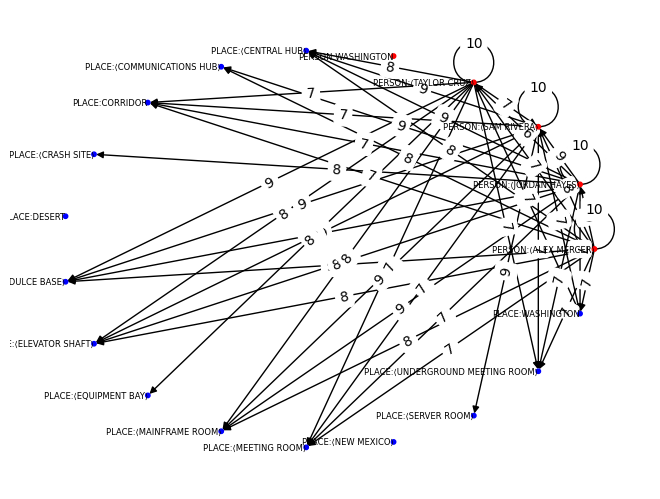

In [9]:
#let's visualize the graph

import networkx as nx
import matplotlib.pyplot as plt



# Create a graph
G = nx.DiGraph()

#add a node for each entity
for index, row in edf1.iterrows():
    G.add_node(row['id'], entity_type=entity_types[0])
    
for index, row2 in edf2.iterrows():
    G.add_node(row2['id'],  entity_type=entity_types[1])
    

#add an edge for each relationship
for index, row3 in rdf.iterrows():
    G.add_edge(row3['in'],row3['out'],label=row3["strength"])




# #generate a color map for rendering the nodes
# color_map = nx.get_node_attributes(G,"entity_type")
# for key in color_map:
#     if color_map[key] == entity_types[0]:
#         color_map[key] = "red"
#     else:
#         color_map[key] = "blue"




color_map =[]
for node in G.nodes.items(): 
    if node[1].__contains__("entity_type") and node[1]["entity_type"] == entity_types[0]:
        color_map.append( "red")
    else:
        color_map.append( "blue")

#add an edge for each relationship
for index, row in rdf.iterrows():
    G.add_edge(row['in'],row['out'],label=row["strength"])


# Draw the graph
#pos = nx.spring_layout(G)  # Use spring layout for node positioning
#pos=nx.fruchterman_reingold_layout(G)
pos=nx.circular_layout(G)
#pos=nx.random_layout(G)
#pos=nx.spectral_layout(G)
# nx.draw(G, pos, with_labels=True, node_size=10, font_size=6, 
#        horizontalalignment='right')
nx.draw(G, pos, with_labels=True, node_size=10, font_size=6, node_color=color_map,
      horizontalalignment='right')
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'))
plt.show()





In [10]:
import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt

def mm(graph,width,height):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.urlsafe_b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string, width=width, height=height))

mm("""graph TD
    A(Marie Curie):::person -->|is a| B(Scientist):::award
    A -->|won| C(Nobel Prize):::award

    classDef person fill:#ff42a1,stroke:#0;
    classDef award fill:#e100ff,stroke:#0;""",300,300)


In [12]:

mermaid_js = "graph LR\n"

#add a node for each entity

badidchars = ['`','⟨','⟩',':'," ",',',' ','.']
badchars = ['⟨','⟩',':',entity_types[0],entity_types[1]]

for index, row in edf1.iterrows():
    id1 = row['id']
    nm1 = row['id']
    for ch in badidchars:
        id1 = id1.replace(ch,"")
    for ch in badchars:
        nm1 = nm1.replace(ch," ").strip()
    mermaid_js += "\t{0}({1}):::{2}\n".format(id1,nm1,entity_types[0])
    
for index, row in edf2.iterrows():
    id1 = row['id']
    nm1 = row['id']
    for ch in badidchars:
        id1 = id1.replace(ch,"")
    for ch in badchars:
        nm1 = nm1.replace(ch," ").strip()
    mermaid_js += "\t{0}({1}):::{2}\n".format(id1,nm1,entity_types[1])


#add an edge for each relationship
for index, row in rdf.iterrows():
    id1 = row['in']
    id2 = row['out']
    
    for ch in badidchars:
        id1 = id1.replace(ch,"")
        id2 = id2.replace(ch,"")
    
        
    mermaid_js += "\t{0}-->|{1}| {2}\n".format(id1,row["strength"],id2)

mermaid_js += """
    classDef {0} fill:#ff42a1,stroke:#0;
    classDef {1} fill:#e100ff,stroke:#0;
    """.format(entity_types[0],entity_types[1])

print(mermaid_js)


mm (mermaid_js,300,1000)

graph LR
	PERSONALEXMERCER(ALEX MERCER):::PERSON
	PERSONJORDANHAYES(JORDAN HAYES):::PERSON
	PERSONSAMRIVERA(SAM RIVERA):::PERSON
	PERSONTAYLORCRUZ(TAYLOR CRUZ):::PERSON
	PERSONWASHINGTON(WASHINGTON):::PERSON
	PLACECENTRALHUB(CENTRAL HUB):::PLACE
	PLACECOMMUNICATIONSHUB(COMMUNICATIONS HUB):::PLACE
	PLACECORRIDOR(CORRIDOR):::PLACE
	PLACECRASHSITE(CRASH SITE):::PLACE
	PLACEDESERT(DESERT):::PLACE
	PLACEDULCEBASE(DULCE BASE):::PLACE
	PLACEELEVATORSHAFT(ELEVATOR SHAFT):::PLACE
	PLACEEQUIPMENTBAY(EQUIPMENT BAY):::PLACE
	PLACEMAINFRAMEROOM(MAINFRAME ROOM):::PLACE
	PLACEMEETINGROOM(MEETING ROOM):::PLACE
	PLACENEWMEXICO(NEW MEXICO):::PLACE
	PLACESERVERROOM(SERVER ROOM):::PLACE
	PLACEUNDERGROUNDMEETINGROOM(UNDERGROUND MEETING ROOM):::PLACE
	PERSONTAYLORCRUZ-->|8| PLACEMAINFRAMEROOM
	PERSONJORDANHAYES-->|6| PERSONTAYLORCRUZ
	PERSONTAYLORCRUZ-->|7| PLACEMEETINGROOM
	PERSONTAYLORCRUZ-->|7| PERSONSAMRIVERA
	PERSONJORDANHAYES-->|7| PLACEWASHINGTON
	PERSONTAYLORCRUZ-->|8| PLACECENTRALHUB
	PERSONJORDANH

In [ ]:
print(recreate_relate_table_surql.format(relation_type = relation_type, entity_type1 = entity_types[0], entity_type2 = entity_types[1]))